<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: West Nile Virus Classification (Part 2 MODELING)
#### Members:Jia Sheng | Wei Hao 

 - [Modeling](#Modeling-&-Feature-Engineering)
 - [Model Intepretation](#Model-Intepretation)
 - [Conclusion & Recommendations](#Conclusion-&-Recommendations)
 - [Citations and Sources](#Citations-and-Sources)

## Modeling

### Importing Libraries

In [67]:
import pandas as pd
pd.reset_option('^display.', silent=True)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re
import nltk
import en_core_web_sm
import shap
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error, plot_roc_curve
#rom sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [2]:
# From Part 1, retriving cleaned train and test datasets

train_df = pd.read_csv('../datasets/cleaned/combined_train_df.csv')
test_df = pd.read_csv('../datasets/cleaned/combined_test_df.csv')

In [3]:
#Create new column variable ('WnvPresent') in our training dataset

train_df['WnvPresent'] = train_df['TotalWNV'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
# Drop TotalNumMosquitos column to stay consistent with test dataset features
train_df = train_df.drop(columns=['TotalNumMosquitos','TotalWNV'])

In [5]:
train_df.columns.difference(test_df.columns)

Index(['WnvPresent'], dtype='object')

In [6]:
test_df.reset_index()
test_df.index = test_df.index + 1 
test_df.head()

,Date,year,month,week_x,Latitude,Longitude,AddressAccuracy,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,...,Trap_T231,Trap_T232,Trap_T233,Trap_T234,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
1,2008-06-11,2008,6,24,41.95469,-87.800991,9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008-06-11,2008,6,24,41.95469,-87.800991,9,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2008-06-11,2008,6,24,41.95469,-87.800991,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008-06-11,2008,6,24,41.95469,-87.800991,9,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,2008-06-11,2008,6,24,41.95469,-87.800991,9,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(train_df.shape)
print(test_df.shape)

(8475, 300)
(116293, 299)


### Base Model

In [64]:
#Develop base model with logistic regression, evaluate metrics via sensitivity and AUC scores, and plot out confusion matrix
def eval_base_model(X_col,y_col):
    
    # Train Test Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(X_col,y_col,test_size=0.3,stratify=y_col,random_state=42)
    
    # Model
    pipe_base_model = Pipeline([
                                    ('scale', StandardScaler()),
                                    ('lr', LogisticRegression(max_iter=5000, solver='liblinear'))
                                ])

    #Fit
    pipe_base_model.fit(X_train,y_train)

    #Evaluate
    y_predict_train = pipe_base_model.predict(X_train)
    y_predict_test = pipe_base_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train).ravel()
    sensitivity_train = tp / (tp + fn)
    tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_predict_test).ravel()
    sensitivity_test = tp1 / (tp1 + fn1)
    train_auc_scores = cross_val_score(pipe_base_model, X_train, y_train,  scoring='roc_auc', cv = 5).mean()
    test_auc_scores = cross_val_score(pipe_base_model, X_test, y_test,  scoring='roc_auc', cv = 5).mean()
    print(f"Sensitivity for train dataset: {sensitivity_train}")
    print(f"Sensitivity for test dataset: {sensitivity_test}\n")
    print(f"AUC Score for train dataset: {train_auc_scores}")
    print(f"AUC Score for test dataset: {test_auc_scores}\n")
    
    #plot
    cf_matrix = confusion_matrix(y_test, y_predict_test)
    plt.figure(figsize = (12,8))
    plt.title(f"Confusion Matrix of Base Model (Logistic Regression)")
    sns.heatmap(cf_matrix, annot=True, xticklabels=['Predicted No WNV','Predicted WNV'], yticklabels=['Actual No WNV','Actual WNV'],fmt='g')
    plt.show
    
    return

In [9]:
X = train_df.drop(columns=['WnvPresent', 'Date'])
y = train_df['WnvPresent']

Sensitivity for train dataset: 0.928125
Sensitivity for test dataset: 0.8686131386861314

AUC Score for train dataset: 0.9930391898927464
AUC Score for test dataset: 0.9824281967435494



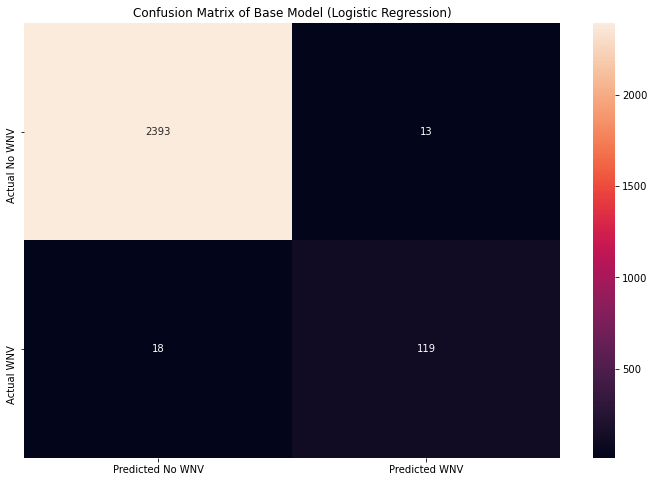

In [65]:
eval_base_model(X,y)

- Observation:    
    - With the sensitivity and AUC score higher for our training dataset as compared to testing dataset, it is observed there may be some overfitting issue.

### Evaluating Other Models Performance without GridSearchCV

In [14]:
#Value Counts Output Variable
train_df.WnvPresent.value_counts(normalize=True)

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

- Observations:

    - As seen from the normalized value count above, our classification training dataset have a severe class imbalance with 5% west nile virus occurences. When working with imbalanced datasets, the difficulty is that most machine learning techniques will overlook the minority class, resulting in poor performance, despite the fact that performance on the minority class is often the most significant.

    - Oversampling the minority class is one way to deal with unbalanced datasets. New samples can be created by synthesizing old ones. The Synthetic Minority Oversampling Technique, or SMOTE for short, is a type of data augmentation for the minority population which we will perform to balance our classes.

In [66]:
def eval_model_peformance(X_col,y_col):
    
    # Train Test Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(X_col,y_col,test_size=0.3,stratify=y_col,random_state=88)
    
    # Dictionary for models
    models_dict = {
                    'lr' : LogisticRegression(solver='liblinear'),
                    'rf' : RandomForestClassifier(),
                    'dt' : DecisionTreeClassifier(),
                    'knn' : KNeighborsClassifier(),
                    'svm' : SVC(),
                    'gb' : GradientBoostingClassifier()
                }
    
    models_df = []
    sensitivity_train_df = []
    sensitivity_test_df = []
    auc_train_df = []
    auc_test_df = []

    # Models  
    for model_name, model_instantiator in models_dict.items():

        pipe_model = Pipeline([
                                ('ss',StandardScaler(with_mean=False)),
                                ('sampling', SMOTE(sampling_strategy='minority', random_state=42)),
                                (model_name,model_instantiator)
                              ])

        #Fit
        pipe_model.fit(X_train,y_train)

        #Evaluate
        y_predict_train = pipe_model.predict(X_train)
        y_predict_test = pipe_model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train).ravel()
        sensitivity_train = tp / (tp + fn)
        tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_predict_test).ravel()
        sensitivity_test = tp1 / (tp1 + fn1)
        train_auc_scores = cross_val_score(pipe_model, X_train, y_train,  scoring='roc_auc', cv = 5).mean()
        test_auc_scores = cross_val_score(pipe_model, X_test, y_test,  scoring='roc_auc', cv = 5).mean()
        print(f"Modeling with {model_instantiator}\n")
        print(f"Sensitivity for train dataset: {sensitivity_train}")
        print(f"Sensitivity for test dataset: {sensitivity_test}")
        print(f"AUC score for train dataset: {train_auc_scores}")
        print(f"AUC score for test dataset: {test_auc_scores}\n")

        #Plot
        cf_matrix = confusion_matrix(y_test, y_predict_test)
        plt.figure(figsize = (12,8))
        plt.title(f"Confusion Matrix based on {model_instantiator}")
        sns.heatmap(cf_matrix, annot=True, xticklabels=['Predicted No WNV','Predicted WNV'], yticklabels=['Actual No WNV','Actual WNV'],fmt='g')
        plt.show

        #Parsing to empty lists
        models_df.append(model_instantiator)
        sensitivity_train_df.append(sensitivity_train)
        sensitivity_test_df.append(sensitivity_test)
        auc_train_df.append(train_auc_scores)
        auc_test_df.append(test_auc_scores)

    compare_models_classifier = pd.DataFrame(
                                                {
                                                'algorithms': models_df,
                                                'Sensitivity Train': sensitivity_train_df,
                                                'Sensitivity Test': sensitivity_test_df,
                                                'AUC Train': auc_train_df,
                                                'AUC Test': auc_test_df,
                                                }
                                            )

    return compare_models_classifier.sort_values(by=['AUC Test','Sensitivity Test'],ascending=False).reset_index(drop=True)

Modeling with LogisticRegression(solver='liblinear')

Sensitivity for train dataset: 0.996875
Sensitivity for test dataset: 0.8905109489051095
AUC score for train dataset: 0.9952585146419939
AUC score for test dataset: 0.9766658272882338

Modeling with RandomForestClassifier()

Sensitivity for train dataset: 1.0
Sensitivity for test dataset: 0.32116788321167883
AUC score for train dataset: 0.8968587203156175
AUC score for test dataset: 0.8502498485900976

Modeling with DecisionTreeClassifier()

Sensitivity for train dataset: 1.0
Sensitivity for test dataset: 0.46715328467153283
AUC score for train dataset: 0.708283192203053
AUC score for test dataset: 0.6392175724125931

Modeling with KNeighborsClassifier()

Sensitivity for train dataset: 1.0
Sensitivity for test dataset: 0.9051094890510949
AUC score for train dataset: 0.9489098836632524
AUC score for test dataset: 0.8659660812150438

Modeling with SVC()

Sensitivity for train dataset: 0.45
Sensitivity for test dataset: 0.4452554744525

,algorithms,Sensitivity Train,Sensitivity Test,AUC Train,AUC Test
0,LogisticRegression(solver='liblinear'),0.996875,0.890511,0.995259,0.976666
1,SVC(),0.450000,0.445255,0.891502,0.892305
2,([DecisionTreeRegressor(criterion='friedman_ms...,0.487500,0.386861,0.864296,0.867847
3,KNeighborsClassifier(),1.000000,0.905109,0.948910,0.865966
4,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.321168,0.896859,0.850250
5,DecisionTreeClassifier(),1.000000,0.467153,0.708283,0.639218


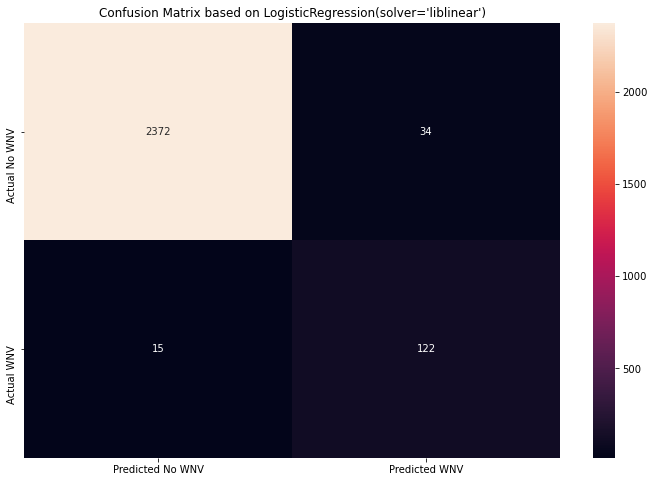

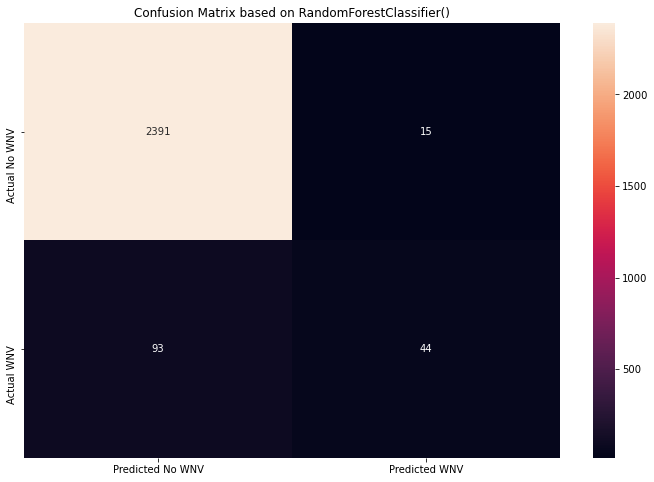

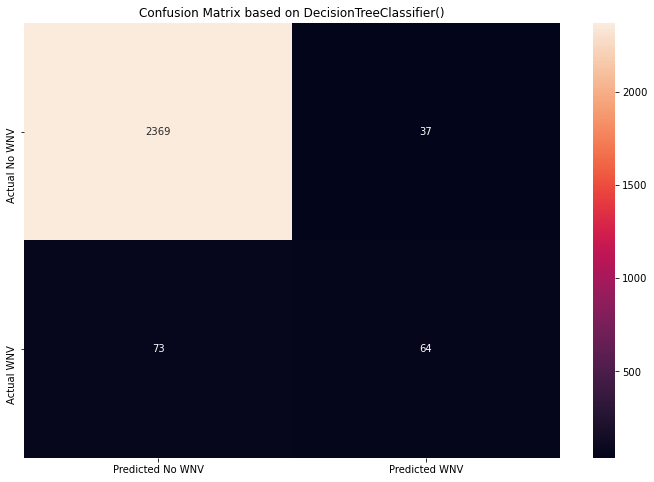

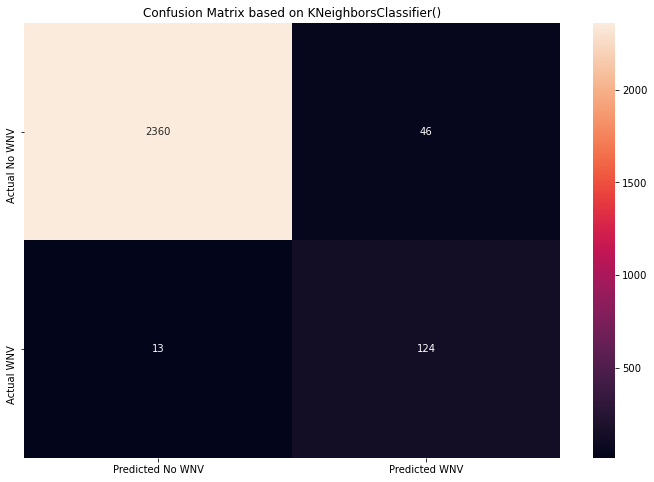

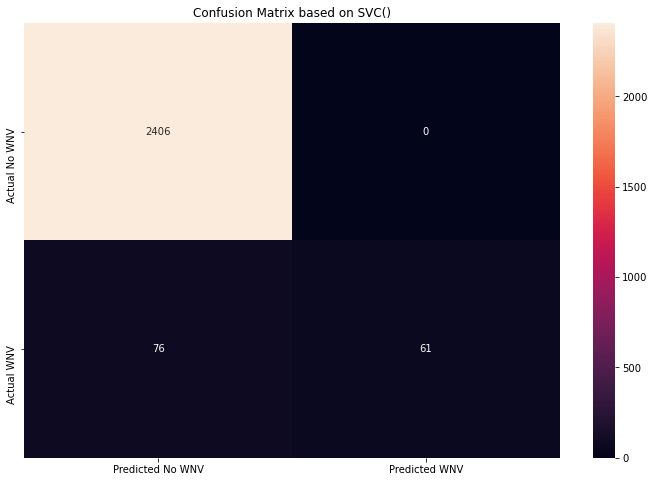

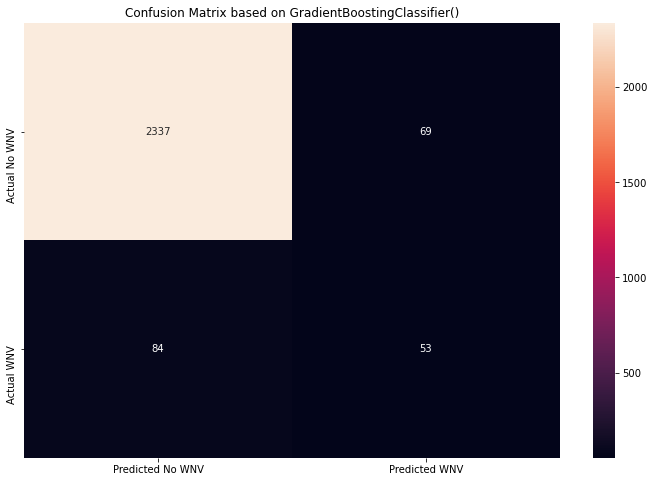

In [68]:
eval_model_peformance(X,y)

- Observations
   - Based on training metric-score and testing metric-scores (Sensitivity and AUC score), all models show signs of overfitting.
   - The top 3 models based on the chosen metrics are SVC, KNNeighbour and LogisticRegression
   - We will carry out hyperparameters tuning for these 3 models before selecting the best model for our use case

### Hyperparameters Tuning

In [12]:
pd.get_option("display.max_columns")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def eval_GS_model_peformance(X_col,y_col):
    
    # Train Test Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(X_col,y_col,test_size=0.3,stratify=y_col,random_state=88)
    
    # Dictionary for models
    
    models_dict = {
                    'lr' : LogisticRegression(solver='liblinear', max_iter=1_000),
                    'knn' : KNeighborsClassifier(),
                    'svm' : SVC()
                }
    
    #Params Dictionary for Hyperparameters Tuninng
    param_dict = {
        'lr' : {
                'lr__penalty' : ['l2'],
                'lr__C' : [0.01, 0.1, 1,10],
                'lr__class_weight' : ['balanced']

        },

         'knn' : {
                 'knn__n_neighbors' : [3, 5, 11, 19],
                 'knn__weights' : ['uniform', 'distance'],
                 'knn__metric' : ['euclidean', 'manhattan']
         },
        
         'svm' : {'svm__C': [0.1,1, 10], 
                  'svm__gamma': [0.1,0.01],
                  'svm__kernel': ['rbf']
        }
    }

    models_df = []
    best_params_df = []
    AUC_train_score_df = []
    AUC_test_score_df = []

    # Models  
    for model_name, model_instantiator in models_dict.items():

        pipe_model = Pipeline([
                                ('ss',StandardScaler(with_mean=False)),
                                ('sampling', SMOTE(sampling_strategy='minority', random_state=42)),
                                (model_name,model_instantiator)
                              ])

        param_dic = param_dict[model_name]

        gs = GridSearchCV(pipe_model, param_grid=param_dic, cv=5, scoring='roc_auc', verbose=10)
        gs.fit(X_train, y_train)

        #Evaluate
        train_params = gs.best_params_
        train_score_df = gs.best_score_
        test_score_df = gs.score(X_test, y_test)

        #Parsing to empty lists
        models_df.append(model_instantiator)
        best_params_df.append(train_params)
        AUC_train_score_df.append(train_score_df)
        AUC_test_score_df.append(test_score_df)

    compare_models_classifier = pd.DataFrame({
                                             'algorithms'   : models_df,
                                             'Best Params'  : best_params_df,
                                             'Train Score'  : AUC_train_score_df,
                                             'Test Score'   : AUC_test_score_df
                                             })

    return compare_models_classifier.sort_values(by=['Test Score','Train Score'],ascending=False).reset_index(drop=True)

In [13]:
eval_GS_model_peformance(X,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2.......
[CV 1/5; 1/4] END lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2;, score=0.995 total time=   0.0s
[CV 2/5; 1/4] START lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2.......
[CV 2/5; 1/4] END lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2;, score=0.991 total time=   0.1s
[CV 3/5; 1/4] START lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2.......
[CV 3/5; 1/4] END lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2;, score=0.990 total time=   0.1s
[CV 4/5; 1/4] START lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2.......
[CV 4/5; 1/4] END lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2;, score=0.997 total time=   0.1s
[CV 5/5; 1/4] START lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2.......
[CV 5/5; 1/4] END lr__C=0.01, lr__class_weight=balanced, lr__penalty=l2;, score=0.996 total time=   0.1s
[CV 1/5; 2

[CV 3/5; 5/16] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.918 total time=   0.3s
[CV 4/5; 5/16] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 4/5; 5/16] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.955 total time=   0.3s
[CV 5/5; 5/16] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 5/5; 5/16] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.986 total time=   0.3s
[CV 1/5; 6/16] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 1/5; 6/16] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.963 total time=   0.2s
[CV 2/5; 6/16] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 2/5; 6/16] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.945 total time=   0.3s
[CV 3/5; 6/16] START knn__metric=euclidean, knn__n_neighbors=11, kn

[CV 4/5; 13/16] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=0.963 total time=   4.0s
[CV 5/5; 13/16] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 5/5; 13/16] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=0.994 total time=   3.7s
[CV 1/5; 14/16] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 1/5; 14/16] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.963 total time=   3.8s
[CV 2/5; 14/16] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 2/5; 14/16] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.962 total time=   3.7s
[CV 3/5; 14/16] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 3/5; 14/16] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance;, score=0.944 total time=   3.6s
[CV 4/5; 14/16] START knn__metric=manhattan, knn__n_neig

[CV 3/5; 6/6] END svm__C=10, svm__gamma=0.01, svm__kernel=rbf;, score=0.991 total time=   3.3s
[CV 4/5; 6/6] START svm__C=10, svm__gamma=0.01, svm__kernel=rbf.................
[CV 4/5; 6/6] END svm__C=10, svm__gamma=0.01, svm__kernel=rbf;, score=0.995 total time=   3.5s
[CV 5/5; 6/6] START svm__C=10, svm__gamma=0.01, svm__kernel=rbf.................
[CV 5/5; 6/6] END svm__C=10, svm__gamma=0.01, svm__kernel=rbf;, score=0.994 total time=   3.3s


,algorithms,Best Params,Train Score,Test Score
0,"LogisticRegression(max_iter=1000, solver='liblinear')","{'lr__C': 0.1, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}",0.996016,0.995194
1,SVC(),"{'svm__C': 1, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}",0.993755,0.993065
2,KNeighborsClassifier(),"{'knn__metric': 'manhattan', 'knn__n_neighbors': 19, 'knn__weights': 'distance'}",0.975735,0.972267


 - Observations:
    - Both the Logistic and SVC models show equal performance when it comes to training and testing gridsearch metric scores. We will use the logistic regression model as our final model in this study because it is the simplest/easier model for the audience to understand.

### Visualizing ROC Curve

We will plot the ROC curves for the 3 models Models i.e. Logistic Regression, SVC model and KNeighborsclassifier models

In [17]:
# Train Test Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=88)

In [20]:
## Apply Standard Scalar
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [21]:
## Resampling to correct out the imabalance in our dataset
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(X_train_scaled, y_train)

In [39]:
print(pd.Series(ysm_train).value_counts())

0    5612
1    5612
Name: WnvPresent, dtype: int64


#### Logistic Regression Model

In [55]:
lr = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', penalty='l2', max_iter=1000)
lr.fit(Xsm_train, ysm_train)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

#### SVC Model

In [56]:
svc = SVC(C=1, gamma=0.01, kernel='rbf')
svc.fit(Xsm_train, ysm_train)

SVC(C=1, gamma=0.01)

#### KNN Model

In [57]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')
knn.fit(Xsm_train, ysm_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


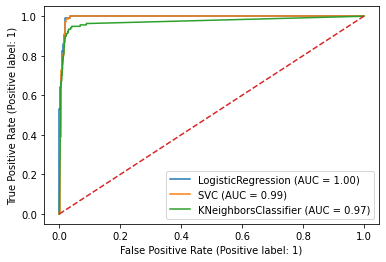

In [58]:
# Plotting the AUC/ROC Curve

lr_disp = plot_roc_curve(lr, X_test_scaled, y_test)
svc_disp = plot_roc_curve(svc, X_test_scaled, y_test, ax = lr_disp.ax_)
knn_disp = plot_roc_curve(knn, X_test_scaled, y_test, ax = lr_disp.ax_)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--') 
plt.show();

 - Observations:
    - The area under the curve (AUC) for LogisticRegression > AUC for SVC and KNN, suggests that the LogisticRegression model is better suited for this classification study.

#### Evaluate the Final Model (Logistic Regression)

In [60]:
#Develop final model with logistic regression, evaluate metrics via sensitivity and AUC scores, and plot out confusion matrix
def eval_final_model(X_col,y_col):
    
    # Train Test Split Dataset
    X_train, X_test, y_train, y_test = train_test_split(X_col,y_col,test_size=0.3,stratify=y_col,random_state=42)
    
    # Model
    pipe_final_model = Pipeline([
                                    ('scale', StandardScaler()),
                                    ('sampling', SMOTE(sampling_strategy='minority', random_state=42)),
                                    ('lr', LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', penalty='l2', max_iter=1000))
                                ])

    #Fit
    pipe_final_model.fit(X_train,y_train)

    #Evaluate
    y_predict_train = pipe_final_model.predict(X_train)
    y_predict_test = pipe_final_model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train).ravel()
    sensitivity_train = tp / (tp + fn)
    tn1, fp1, fn1, tp1 = confusion_matrix(y_test, y_predict_test).ravel()
    sensitivity_test = tp1 / (tp1 + fn1)
    train_auc_scores = cross_val_score(pipe_final_model, X_train, y_train,  scoring='roc_auc', cv = 5).mean()
    test_auc_scores = cross_val_score(pipe_final_model, X_test, y_test,  scoring='roc_auc', cv = 5).mean()
    print(f"Sensitivity for train dataset: {sensitivity_train}")
    print(f"Sensitivity for test dataset: {sensitivity_test}\n")
    print(f"AUC Score for train dataset: {train_auc_scores}")
    print(f"AUC Score for test dataset: {test_auc_scores}\n")
    
    #plot
    cf_matrix = confusion_matrix(y_test, y_predict_test)
    plt.figure(figsize = (12,8))
    plt.title(f"Confusion Matrix of Final Model (Logistic Regression)")
    sns.heatmap(cf_matrix, annot=True, xticklabels=['Predicted No WNV','Predicted WNV'], yticklabels=['Actual No WNV','Actual WNV'],fmt='g')
    plt.show
    
    return

Sensitivity for train dataset: 1.0
Sensitivity for test dataset: 0.9416058394160584

AUC Score for train dataset: 0.9934844060266379
AUC Score for test dataset: 0.9854756927371036



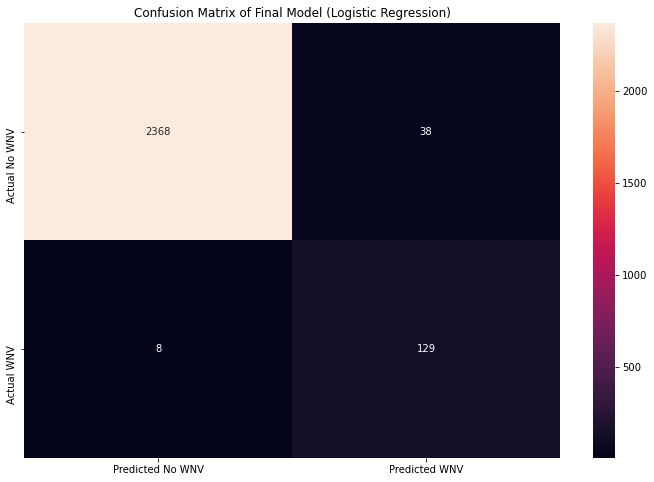

In [63]:
eval_final_model(X,y)

 - Observations:
    - Both metrics (Sensitivity and AUC) for our final model built with Logistic Regression improved after hyperparameters tuning and balancing our dataset.
    - The base Model Sensitivity for test score was 0.8686, improved to 0.9416 with our final model
    - The base Model AUC for test score was 0.9824, slight improvement to 0.9855 with our final model

In [81]:
#### Predict WNV on our test datasets

In [92]:
test_df.drop(columns='Date', inplace=True)

In [115]:
#match the feature names between train and test datasets
test_df = test_df[X.columns]

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=88)

#Instantiate model with best hyperparameters
lr = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', penalty='l2', max_iter=1000)

#Instantiate StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(test_df)

#Instantiate SMOTE
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(X_train_scaled, y_train)

#Fit model with training dataset
lr.fit(Xsm_train, ysm_train)

#predicting proba with test dataset
y_test_predict = lr.predict_proba(X_test_scaled)[:,1]

In [118]:
test_df['WnvPresent'] = y_test_predict

In [126]:
test_df = test_df.reset_index().rename(columns={'index': 'Id'})

In [130]:
kaggle_submission = test_df[['Id','WnvPresent']]

In [132]:
kaggle_submission.to_csv('../datasets/cleaned/kaggle_submission.csv',index=False)

### Model Intepretation

We can plot the SHAP values ([*source3*](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)) of each feature for each sample to gain an understanding of which features are most significant for a model. The plot below shows the distribution of the impacts each feature has on the model output by sorting features with the sum of SHAP value magnitudes across all samples. The color represents the value of the characteristic (red high, blue low).

In [69]:
# load JS visualization code to notebook
shap.initjs()

#### Most Useful Features

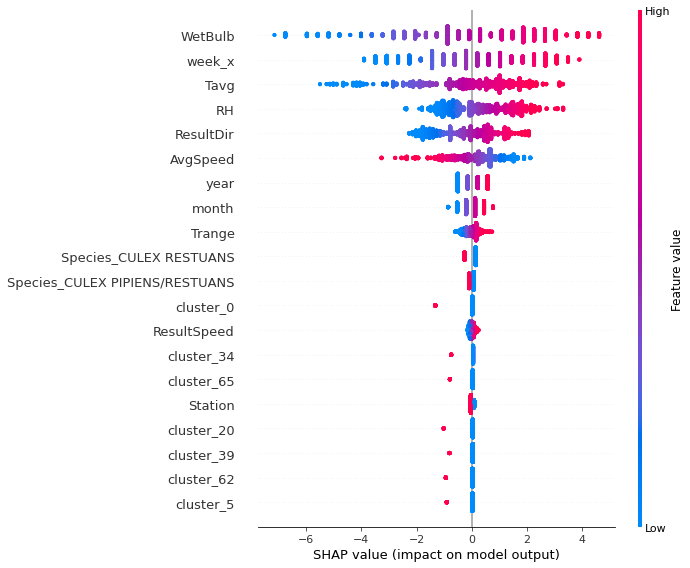

In [79]:
#Summary Plot
shap_explainer = shap.Explainer(lr, X_test)
shap_values = shap_explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Summary Plot
- The summmary plot demonstrates the following information:
    - 1) Feature importance: The variable names are listed on the y-axis in ascending order of importance from top to bottom. 
    - 2) Impact: The SHAP value is plotted on the x-axis. Indicates how much the log-odds have changed. The likelihood of success can be calculated using this value.
    - 3) Featyre value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

## Conclusion & Recommendations

**Findings from our model:**
- Using Logistic Regression as our final model, we achieved an ROC_AUC of 0.9855 and sensitivity score of 0.9416
- From the summary plot, it is observed the top features are mostly related to weather parameters. More WNV are present if humidity and weather temperature are high. Interestingly, the opposite is true for windspeed; meaning to say there are fewer incidences of WNV when there is a high windspeed.
- We also discovered that WNV is more likely to occur during specific weeks of the year, and that spraying efforts should be concentrated during these weeks.
- Our model also discovered that location is not a major predictor of WNV detection, implying that mosquitoes could breed anywhere with favorable weather/environmental conditions. 
- Particular mosquito breeds (pipens/restuans species) are more susceptible to WNV infection.


**Recommendations**
- Due to a lack of spraying data, drawing any conclusions on the efficiency of pesticide spray in reducing mosquito populations is difficult. To better understand the effect of pesticide on mosquitoes and investigate the effective time of the spray, it is recommended that spraying begin in early summer and continue until late July/early August, when the number of mosquitoes normally peaks.


## Citations and Sources

The sources used in this analysis:
- Source1: https://www.cdc.gov/mmwr/preview/mmwrhtml/ss5902a1.htm
- Source2: https://github.com/cs109/2015/blob/master/Lectures/01-Introduction.pdf
- Source3: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d